# Viewing the low-level thermodynamic and kinematic trends from Single site Sondes launched during CROCUS UC IOP 1&2

This notebook is meant for viewing trends for individual sounding sites over the IOP. Could I have done this with the other notebook? Yes. But this is just easier so you don't have to rework the code at all. :)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc
import re

In [35]:
def filter_data_every_10mb(data):
    unique_pressures = np.arange(800, 1001, 10)  # Define the range of pressure levels you are interested in
    filtered_data_list = []
    
    for level in unique_pressures:
        # Find all data points within the tolerance of 1 hPa
        within_tolerance = data[np.isclose(data['P'] % 10, level % 10, atol=1)]
        if not within_tolerance.empty:
            # Find the data point closest to the target pressure level
            closest = (np.abs(within_tolerance['P'] - level)).idxmin()
            filtered_data_list.append(within_tolerance.loc[closest])
    
    filtered_data = pd.DataFrame(filtered_data_list)
    return filtered_data

In [37]:
def read_gps_file(file_path):
    df = pd.read_csv(file_path, 
                     skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10],
                     sep=r'\s+', encoding='latin1')
    good_columns = df.columns[1:]
    df = df.drop(columns="HeightE")
    df.columns = good_columns
    p = df['P'].values * units.hPa
    z = df['HeightMSL'].values * units.m
    T = df['Temp'].values * units.degC
    Td = df['Dewp'].values * units.degC
    wind_speed = df['Speed'].values * units.knots
    wind_dir = df['Dir'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    df = pd.DataFrame({'P': p.magnitude, 'T': T.magnitude, 'TD': Td.magnitude, 'u': u.magnitude, 'v': v.magnitude, 'z': z.magnitude})
    return df.dropna()

def read_rts_file(file_path):
    df = pd.read_fwf(file_path, delimiter='\t', encoding='iso-8859-1')
    df = df.rename(columns={'Pressure[mbar]': 'P', 'T[°C] ': 'T', 'Dew [°C]': 'TD', 'Wsp [m/s]': 'wind_speed', 'Wdir [°]': 'wind_dir'})
    p = df['P'].values * units.hPa
    T = df['T'].values * units.degC
    Td = df['TD'].values * units.degC
    wind_speed = df['wind_speed'].values * 1.94384  # Convert m/s to knots manually
    wind_speed_units = wind_speed * units.knots  # Add units to the converted wind speed
    wind_dir = df['wind_dir'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed_units, wind_dir)
    df = pd.DataFrame({'P': p.magnitude, 'T': T.magnitude, 'TD': Td.magnitude, 'u': u.magnitude, 'v': v.magnitude})
    return df.dropna()

def determine_label(file_path):
    if 'GPS' in file_path:
        return 'Humboldt Park'
    elif 'Sonde1' in file_path:
        return 'Shedd Aquarium'
    elif 'Sonde3' in file_path:
        if '0727' in file_path or '0728' in file_path:
            return 'Woodlawn'
        else:
            return 'Gary Comer'
    return 'Unknown'

def extract_time(file_path):
    match = re.search(r'_(\d{4})_', file_path)
    if match:
        return match.group(1)
    return 'Unknown'

def generate_title_and_filename(files):
    times = [extract_time(file) for file in files]
    locations = set(determine_label(file) for file in files)
    title = f'Skew-T Trend for {", ".join(locations)} at {", ".join(times)}z'
    filename = f'skewt_trend_{"_".join(locations)}_{"_".join(times)}.png'
    return title, filename

Could not plot dew point for 20240728_0000_Sonde3_RTS.txt: 'Unit' object has no attribute 'update'


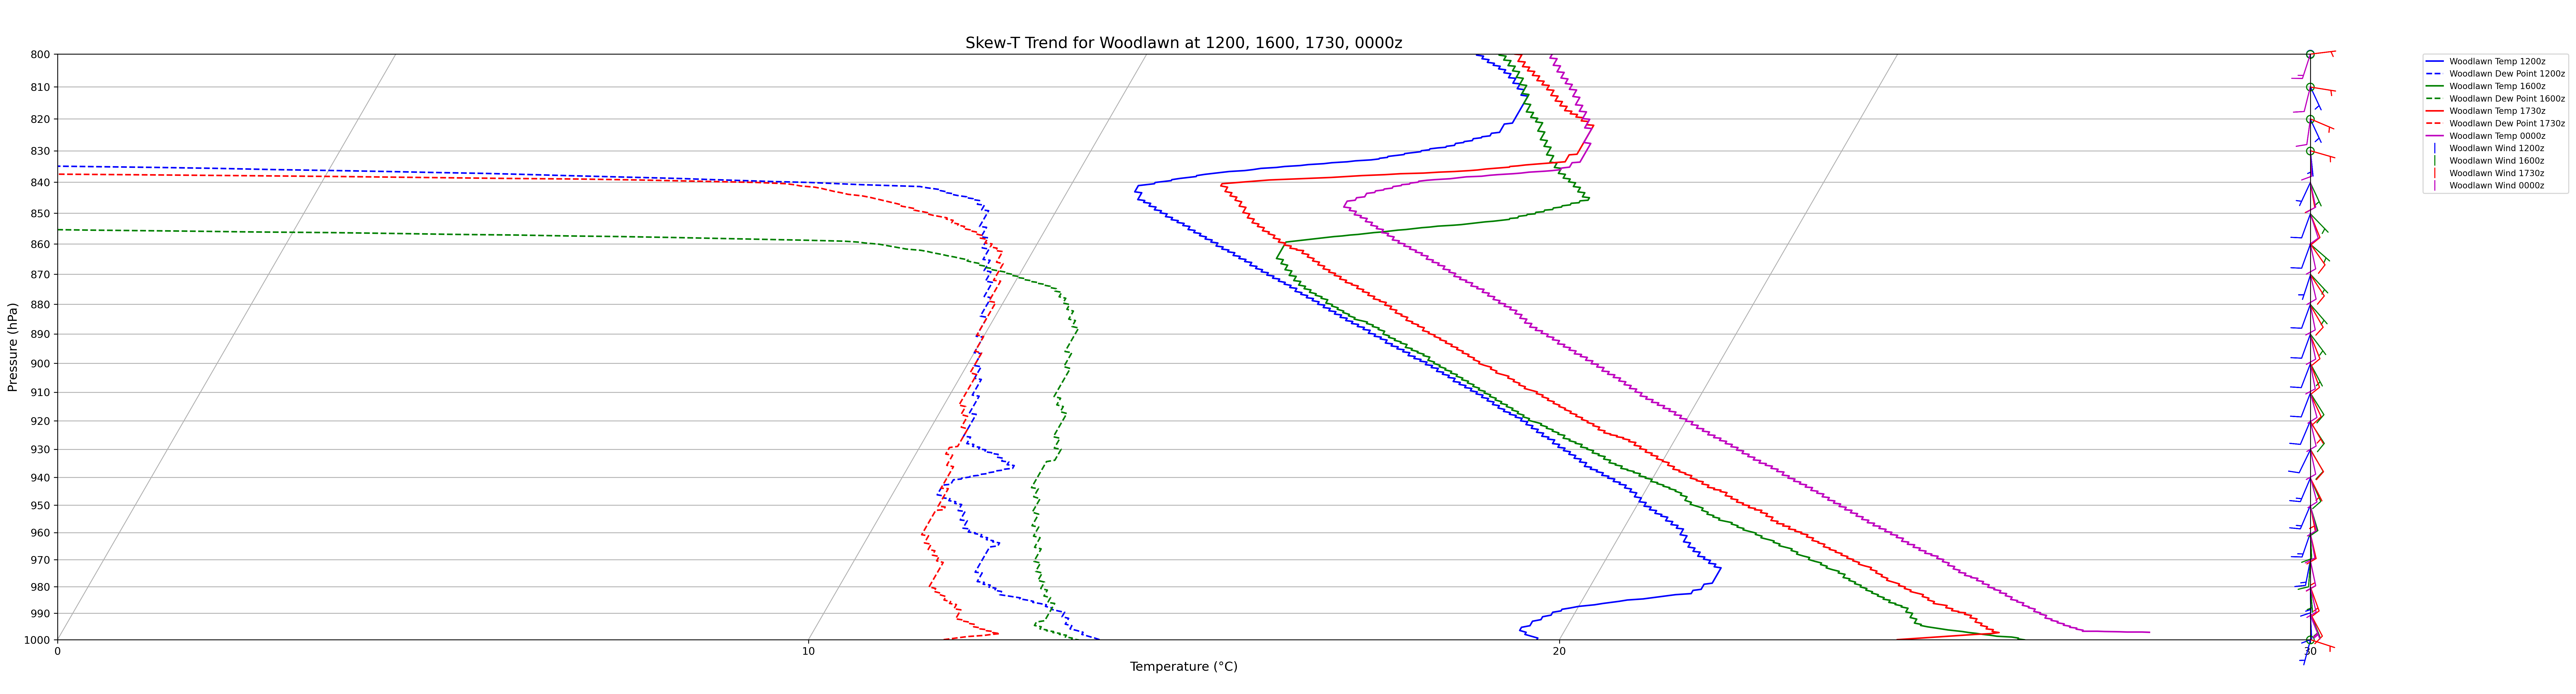

In [45]:
files = [
    'Insert','your','files','here'
]

# Dynamically read the data from each file
data_list = []
for file in files:
    if 'GPS' in file:
        data_list.append(read_gps_file(file))
    else:
        data_list.append(read_rts_file(file))

# Filter data to include only the closest point to each pressure level at intervals of 10 mb
filtered_data_list = [filter_data_every_10mb(data) for data in data_list]

# Create a new figure
fig = plt.figure(figsize=(10, 15), dpi=300)
rect = [-1, -1, 3, 1000]  # Adjust rect parameter accordingly
skew = SkewT(fig, rect=rect)

# Plot the data
colors = ['b', 'g', 'r', 'm', 'purple']
for data, color, file in zip(data_list, colors, files):
    label = determine_label(file)
    time = extract_time(file)
    try:
        if 'T' in data and not data['T'].empty and 'P' in data and not data['P'].empty:
            skew.plot(data['P'], data['T'], color=color, label=f'{label} Temp {time}z')
    except Exception as e:
        print(f"Could not plot temperature for {file}: {e}")
    try:
        if 'TD' in data and not data['TD'].empty and 'P' in data and not data['P'].empty:
            skew.plot(data['P'], data['TD'], color=color, linestyle='--', label=f'{label} Dew Point {time}z')
    except Exception as e:
        print(f"Could not plot dew point for {file}: {e}")

# Plot wind barbs at intervals of 10 mb
for data, color in zip(filtered_data_list, colors):
    try:
        if 'u' in data and not data['u'].empty and 'v' in data and not data['v'].empty and 'P' in data and not data['P'].empty:
            skew.plot_barbs(data['P'], data['u'], data['v'], color=color)
    except Exception as e:
        print(f"Could not plot wind barbs for {file}: {e}")

# Create custom legend
handles, labels = skew.ax.get_legend_handles_labels()
for file, color in zip(files, colors):
    label = determine_label(file)
    time = extract_time(file)
    if f'{label} Wind {time}z' not in labels:
        handles.append(plt.Line2D([0], [0], color=color, marker='|', linestyle='None', markersize=10, label=f'{label} Wind {time}z'))

skew.ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=8)

# Set the limits for zooming and custom y-axis ticks
skew.ax.set_xlim(0, 30)  # Adjust temperature range if needed
skew.ax.set_ylim(1000, 800)  # Adjust pressure range if needed
skew.ax.set_yticks(np.arange(800, 1001, 10))  # Adjust pressure levels if needed

# Add gridlines, title, and labels
title, filename = generate_title_and_filename(files)
skew.ax.grid(True)
skew.ax.set_title(title, fontsize=15)
skew.ax.set_xlabel('Temperature (°C)', fontsize=12)
skew.ax.set_ylabel('Pressure (hPa)', fontsize=12)

# Save and display the plot
plt.savefig(filename, bbox_inches='tight', dpi=300)
plt.show()
